In [1]:
import importlib
from pathlib import Path
import pyBigWig

import numpy as np
import pandas as pd
import scipy
from scipy.stats import pearsonr

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import logomaker as lm

import tensorflow as tf

from Modules import utils, tf_utils, plot_utils
from Modules.tf_utils import mae_cor, correlate, get_profile
import kMC_sequence_design as kmc
import kMC_sequence_design_v2 as kmc_v2
from kMC_sequence_design import get_profile_hint, rmse, GC_energy, get_profile_chunk

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
# sns.set_theme()

2024-09-01 17:59:37.979265: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


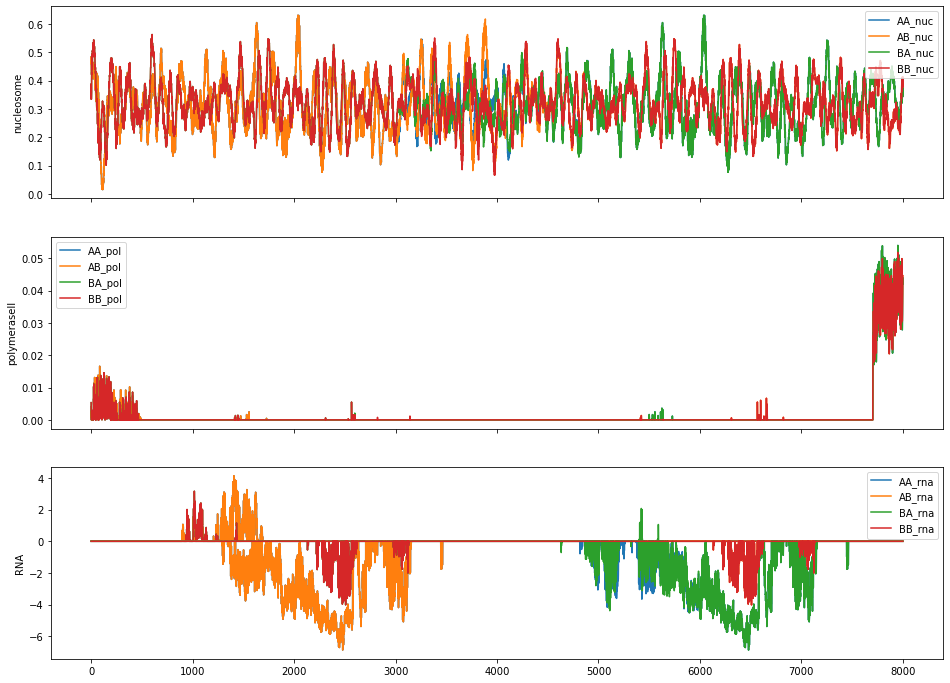

In [4]:
df_preds = pd.concat(
    [
        pd.read_csv(
            "/home/alex/shared_folder/SCerevisiae/generated/Tosend20240514/preds_nuc_SynAB_8kb_4config.csv",
            index_col=0,
        ).rename({col: f"{col}_nuc" for col in ["AA", "AB", "BA", "BB"]}, axis=1),
        pd.read_csv(
            "/home/alex/shared_folder/SCerevisiae/generated/Tosend20240514/preds_pol_SynAB_8kb_4config.csv",
            index_col=0,
        ).rename({col: f"{col}_pol" for col in ["AA", "AB", "BA", "BB"]}, axis=1),
        pd.read_csv(
            "/home/alex/shared_folder/SCerevisiae/generated/Tosend20240514/preds_rna_SynAB_8kb_4config.csv",
            index_col=0,
        ).rename(
            {
                f"{col}_{sense}": f"{col}_rna_{sense}"
                for col in ["AA", "AB", "BA", "BB"]
                for sense in ["for", "rev"]
            },
            axis=1,
        ),
    ],
    axis=1,
)
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
df_preds.loc[:, [f"{col}_nuc" for col in ["AA", "AB", "BA", "BB"]]].plot(ax=axes[0])
df_preds.loc[:, [f"{col}_pol" for col in ["AA", "AB", "BA", "BB"]]].plot(ax=axes[1])
df_preds.loc[:, [f"{col}_rna_for" for col in ["AA", "AB", "BA", "BB"]]].plot(ax=axes[2])
(-df_preds).loc[:, [f"{col}_rna_rev" for col in ["AA", "AB", "BA", "BB"]]].plot(
    ax=axes[2], color=colors[:4], legend=False
)
han, lab = axes[2].get_legend_handles_labels()
lab = [l[:-4] for l in lab]
axes[2].legend(han[:4], lab[:4])
axes[0].set_ylabel("nucleosome")
axes[1].set_ylabel("polymeraseII")
axes[2].set_ylabel("RNA")
plot_utils.save_fig_and_values(
    fig,
    "/home/alex/shared_folder/SCerevisiae/generated/Tosend20240514/preds_SynAB_8kb_4config",
    format="svg",
)

In [3]:
importlib.reload(utils)
importlib.reload(tf_utils)
importlib.reload(plot_utils)
importlib.reload(kmc)
importlib.reload(kmc_v2)

<module 'kMC_sequence_design_v2' from '/home/alex/mnhn-internship_DeepCNN_ChIP-seq/kMC_sequence_design_v2.py'>

Models

In [2]:
model_pol_name = "model_myco_pol_17"
# with tf.distribute.MirroredStrategy().scope():
model_pol = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_pol_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_nuc_name = "model_myco_nuc_2"
model_nuc = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_nuc_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_coh_name = "model_myco_coh_14"
model_coh = tf.keras.models.load_model(
    f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_coh_name}/model",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_rna_name = "weight_CNN_RNA_seq_2001_12_8_4_SRR7131299"  # order 'ATGC'
model_rna = tf.keras.models.load_model(
    f"/home/alex/shared_folder/JB_seqdes/{model_rna_name}.hdf5",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_nuc_etienne_name = "weights_with_rev_compl_rep2"
model_nuc_etienne = tf.keras.models.load_model(
    f"/home/alex/shared_folder/JB_seqdes/{model_nuc_etienne_name}.hdf5",
    custom_objects={"correlate": correlate, "mae_cor": mae_cor},
)
model_rna.input_shape

2024-09-01 17:59:45.699951: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-09-01 17:59:45.810160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-01 17:59:45.810883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-09-01 17:59:45.810929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-01 17:59:45.811527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

(None, 2001, 4, 1)

In [3]:
# model_nuc.save(f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_nuc_name}/model_nuc.h5")
# model_pol.save(f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_pol_name}/model_pol.h5")
# model_coh.save(f"/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_coh_name}/model_coh.h5")

In [18]:
for flank_idx in [4, 5, 6, 7, 8, 9, 10]:
    exp_name = f"4kb_lowpol_10seq_flanksInt{flank_idx}_v2"
    optimized_seqs = np.load(
        f"/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step499.npy"
    )
    to_predict = optimized_seqs.ravel()
    with np.load(
        f"/home/alex/shared_folder/SCerevisiae/data/S288c_siteManon_Int{flank_idx}_1kbflanks_ACGTidx.npz"
    ) as f:
        flank_left = f["left"]
        flank_right = f["right"]
    flanks = (flank_left, flank_right)  # "self"  #
    preds_pol, indices_pol = get_profile_chunk(
        to_predict, model_pol, 2048, 128, middle=True, return_index=True, flanks=flanks
    )
    preds_pol_rev, indices_pol_rev = get_profile_chunk(
        to_predict,
        model_pol,
        2048,
        128,
        reverse=True,
        middle=True,
        return_index=True,
        flanks=flanks,
    )
    preds_nuc, indices_nuc = get_profile_chunk(
        to_predict, model_nuc, 2001, return_index=True, flanks=flanks
    )
    preds_nuc_rev, indices_nuc_rev = get_profile_chunk(
        to_predict, model_nuc, 2001, reverse=True, return_index=True, flanks=flanks
    )
    preds_rna, indices_rna = get_profile_chunk(
        to_predict,
        model_rna,
        2001,
        one_hot_converter=lambda x: utils.np_idx_to_one_hot(
            x, order="ATGC", extradims=-1
        ),
        return_index=True,
        flanks=flanks,
    )
    preds_rna_rev, indices_rna_rev = get_profile_chunk(
        to_predict,
        model_rna,
        2001,
        reverse=True,
        one_hot_converter=lambda x: utils.np_idx_to_one_hot(
            x, order="ATGC", extradims=-1
        ),
        return_index=True,
        flanks=flanks,
    )
    # Merge forward and reverse
    length = to_predict.shape[-1]
    merge_pol = utils.mean_on_index(
        (indices_pol, preds_pol), (indices_pol_rev, preds_pol_rev), length=length
    )
    merge_nuc = utils.mean_on_index(
        (indices_nuc, preds_nuc), (indices_nuc_rev, preds_nuc_rev), length=length
    )
    # Save predictions on first and last sequences
    filename = utils.safe_filename(
        f"/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/preds_end_concat.npz"
    )
    np.savez(
        filename,
        preds_nuc=merge_nuc,
        preds_pol=merge_pol,
        preds_rna=preds_rna,
        preds_rna_rev=preds_rna_rev,
    )

In [3]:
flank_idx = 2
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/data/S288c_siteManon_Int{flank_idx}_16kbflanks_ACGTidx.npz"
) as f:
    flank_left = f["left"]
    flank_right = f["right"]

In [4]:
from Bio import SeqIO
manonseqfile = "/home/alex/shared_folder/SCerevisiae/data/SynC 1.fa"
manonseq = list({seq.id: str(seq.seq) for seq in SeqIO.parse(manonseqfile, format="fasta")}.values())[0]
to_predict = utils.str_to_idx(manonseq)
to_predict

array([2, 3, 0, ..., 2, 3, 3])

In [12]:
for flank_idx in [2, 4, 5, 6, 7, 8, 9, 10]:
    with np.load(
        f"/home/alex/shared_folder/SCerevisiae/data/S288c_siteManon_Int{flank_idx}_16kbflanks_ACGTidx.npz"
    ) as f:
        flank_left = f["left"]
        flank_right = f["right"]
    flanks = (flank_left, flank_right)  # "self"  #
    preds_pol, indices_pol = get_profile_chunk(
        to_predict, model_pol, 2048, 128, middle=True, return_index=True, flanks=flanks
    )
    preds_pol_rev, indices_pol_rev = get_profile_chunk(
        to_predict,
        model_pol,
        2048,
        128,
        reverse=True,
        middle=True,
        return_index=True,
        flanks=flanks,
    )
    preds_nuc, indices_nuc = get_profile_chunk(
        to_predict, model_nuc, 2001, return_index=True, flanks=flanks
    )
    preds_nuc_rev, indices_nuc_rev = get_profile_chunk(
        to_predict, model_nuc, 2001, reverse=True, return_index=True, flanks=flanks
    )
    preds_coh, indices_coh = get_profile_chunk(
        to_predict, model_coh, 32768, 128, middle=False, return_index=True, flanks=flanks
    )
    preds_coh_rev, indices_coh_rev = get_profile_chunk(
        to_predict,
        model_coh,
        32768,
        128,
        reverse=True,
        middle=False,
        return_index=True,
        flanks=flanks,
    )
    preds_rna, indices_rna = get_profile_chunk(
        to_predict,
        model_rna,
        2001,
        one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order="ATGC", extradims=-1),
        return_index=True,
        flanks=flanks,
    )
    preds_rna_rev, indices_rna_rev = get_profile_chunk(
        to_predict,
        model_rna,
        2001,
        reverse=True,
        one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order="ATGC", extradims=-1),
        return_index=True,
        flanks=flanks,
    )
    # Merge forward and reverse
    length = to_predict.shape[-1]
    merge_pol = utils.mean_on_index(
        (indices_pol, preds_pol), (indices_pol_rev, preds_pol_rev), length=length
    )
    merge_nuc = utils.mean_on_index(
        (indices_nuc, preds_nuc), (indices_nuc_rev, preds_nuc_rev), length=length
    )
    merge_coh = utils.mean_on_index(
        (indices_coh, preds_coh), (indices_coh_rev, preds_coh_rev), length=length
    )
    # Save predictions on first and last sequences
    filename = utils.safe_filename(
        # f"/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/preds_end_concat.npz"
        f"/home/alex/shared_folder/SCerevisiae/results/generated/4kb_lowpol_10seq_randomflanks_v8/preds_SynC 1_flanksInt{flank_idx}.npz"
    )
    np.savez(
        filename,
        preds_nuc=merge_nuc,
        preds_pol=merge_pol,
        preds_coh=merge_coh,
        preds_rna=preds_rna,
        preds_rna_rev=preds_rna_rev,
    )

/home/alex/shared_folder/SCerevisiae/results/generated/4kb_lowpol_10seq_randomflanks_v8/preds_SynC 1_flanksInt2.npz exists, changing filename to /home/alex/shared_folder/SCerevisiae/results/generated/4kb_lowpol_10seq_randomflanks_v8/preds_SynC 1_flanksInt2(1).npz


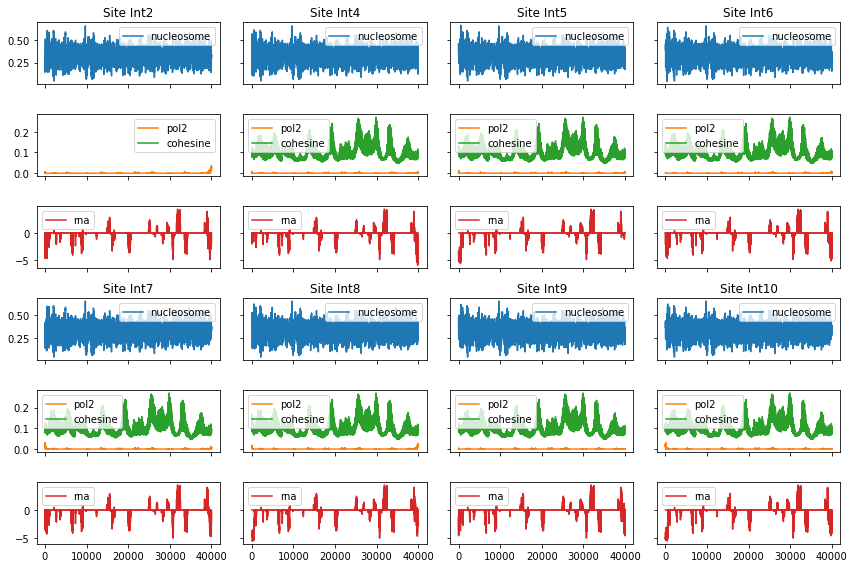

In [24]:
fig, axes = plt.subplots(6, 4, figsize=(12, 8), facecolor='w', layout='tight', sharey="row", sharex=True)
for i, flank_idx in enumerate([2, 4, 5, 6, 7, 8, 9, 10]):
    with np.load(
        f"/home/alex/shared_folder/SCerevisiae/results/generated/4kb_lowpol_10seq_randomflanks_v8/preds_SynC 1_flanksInt{flank_idx}.npz"
    ) as f:
        preds_nuc = f["preds_nuc"]
        preds_pol = f["preds_pol"]
        try:
            preds_coh = f["preds_coh"]
        except KeyError:
            preds_coh = 0
        preds_rna = f["preds_rna"]
        preds_rna_rev = f["preds_rna_rev"]
    axes[3*(i//4), i%4].set_title(f"Site Int{flank_idx}")
    axes[3*(i//4), i%4].plot(preds_nuc, label="nucleosome")
    axes[3*(i//4)+1, i%4].plot(preds_pol, label="pol2", color=colors[1])
    axes[3*(i//4)+1, i%4].plot(preds_coh, label="cohesine", color=colors[2])
    axes[3*(i//4)+2, i%4].plot(preds_rna, label='rna', color=colors[3])
    axes[3*(i//4)+2, i%4].plot(-preds_rna_rev, color=colors[3])
for ax in axes.flatten():
    ax.legend()

In [10]:
# Save predictions on first and last sequences
filename = utils.safe_filename(
    f"/home/alex/shared_folder/SCerevisiae/results/generated/4kb_lowpol_10seq_randomflanks_v8/preds_SynC 1_flanksInt2.npz"
)
np.savez(
    filename,
    preds_nuc=merge_nuc,
    preds_pol=merge_pol,
    preds_coh=merge_coh,
    preds_rna=preds_rna,
    preds_rna_rev=preds_rna_rev,
)

In [18]:
with np.load("/home/alex/shared_folder/SCerevisiae/results/generated/4kb_lowpol_10seq_randomflanks_v8/preds_concat40kb_lowpol_norna_fwrna_rvrna_flanksInt2.npz") as f:
    preds_nuc_concat40kb = f["preds_nuc"]
    preds_pol_concat40kb = f["preds_pol"]
    preds_rna_concat40kb = f["preds_rna"]
    preds_rna_rev_concat40kb = f["preds_rna_rev"]
preds_pol_concat40kb.shape

(3, 40000)

In [29]:
sites = np.array([517, 1712, 5625, 7177, 8936, 13444, 14604, 17216, 18864, 20235, 30690, 32089, 33104, 33856, 34132, 34563, 34917, 36406, 38772])

In [43]:
len(sites)

19

0.00030824193 0.00022123756259679795 0.00014795303363353014


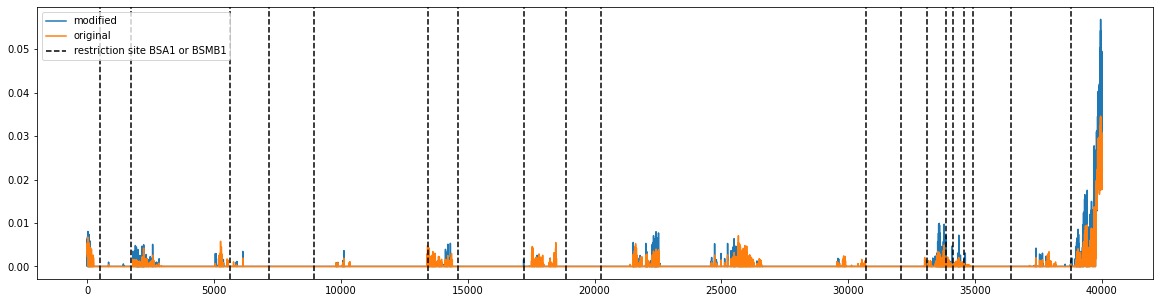

In [42]:
start = 000
stop = start + 40000
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w')
ax.plot(np.arange(start, stop), preds_pol[start:stop], label="modified")
ax.plot(np.arange(start, stop), preds_pol_concat40kb[0, start:stop], label="original")
linelab = "restriction site BSA1 or BSMB1"
for site in sites:
    if site >= start and site < stop:
        ax.axvline(x=site, color='k', linestyle='--', label=linelab)
        linelab = None
plt.legend()
print(preds_pol.mean(), preds_pol_concat40kb[0].mean(), np.abs(preds_pol_concat40kb[0]-preds_pol).mean())

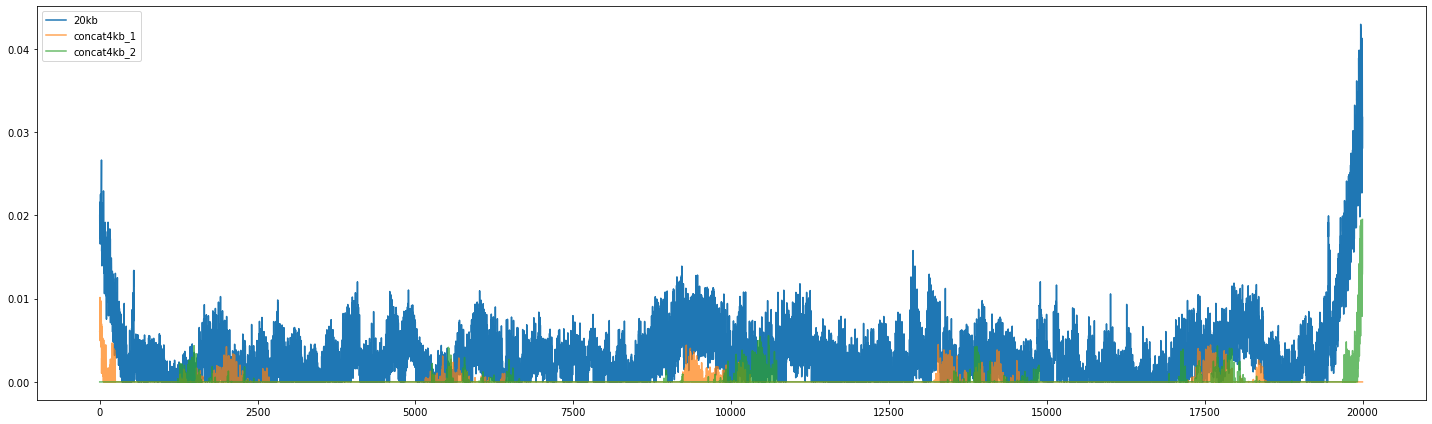

In [14]:
with np.load(
    "/home/alex/shared_folder/SCerevisiae/results/generated/4kb_lowpol_10seq_flanksInt2_v2/preds_end_concat.npz"
) as f:
    preds_concat4kb = f["preds_pol"]
with np.load(
    "/home/alex/shared_folder/SCerevisiae/results/generated/20kb_lowpol_1seq_flanksInt2_longer_continued4/preds_start_end.npz"
) as f:
    preds_20kb = f["preds_pol"][0, -1]
fig, ax = plt.subplots(1, 1, figsize=(20, 6), facecolor="w", layout="tight")
ax.plot(preds_20kb, label="20kb")
ax.plot(preds_concat4kb[:20000], label="concat4kb_1", alpha=0.7)
ax.plot(preds_concat4kb[20000:], label="concat4kb_2", alpha=0.7)
ax.legend()

In [4]:
genome_Manon = utils.read_fasta(
    "/home/alex/shared_folder/SCerevisiae/data/MPerrot_2024_04_16/S288c_SynC17C19.fa"
)
genome_Manon = {k.split()[0]: v for k, v in genome_Manon.items()}
print(list(genome_Manon.keys()))
genome_Struhl = utils.read_fasta(
    "/home/alex/shared_folder/SCerevisiae/data/JSerizay_2024_04_12/sacCer3_pCC1random_nochrM.fa"
)
print(list(genome_Struhl.keys()))

['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII', 'VIII', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI']
['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrXVII']


In [5]:
seqA = "ACTATCAGGAGACAGCAGTCACTATTTGAGGCACCAAATGAACAACACCGTTTCGGGGAAATATTCCGAATAATGTTTGGAATTGTTATCCGAAGTTTAAGTTCCAAATGACAATGCCCTGATACCTAAGTCCTCTGTTTCTACCTATTCTAATTTTATTAATTGACAATGAATGCTTTAATTCTTGGACATCAAGATCCGGACAATAATCATCAGTCGCAACTAATAATCAGTGACTAGAATTGTGCTATATTGGCTAGATCCTCCGGTTCCATGATATTGGATAGAAGCGTTAAGAGGTCGGACTACAACCTGTCTCGATTAGTACTATATGTCGAGCTTAAAAGGGCACTTCATCGAAATATAGGGAATCATATCCTGGCTTGTAAATACCGTTGCTCTTTCAGGTCCATAGTAATCCAAAGTAAGCCCTGGGTTGATTTGCTATGATCAATAGTACTGTCGATTGCGGACATCTAAAACTTGCTGGGATAGTGCTTGATATTAGGAAAATATTCTTAGACTTAACTTGGTCATTTGATATATCTACAACCTTAGGGATATGATATGTTCAAAGCAACGCCAAATAAGCAACAATTTACTGATATTCCTTGAAGCTTCAGCGAACGATTTTCAAAGTCTGGGCACTTATACCTACCAGTAGTCTGATGGGCATCAAGTGTACAAGAATACAAGCTATAAACCAGGTTCGAAGGAATTTCTGAAGTGAGAGTTCCTTCGAGGGACCTATTGATTAGTTGGTAGGGTGGGATGATTTATCTATAAAGCGTTTCCTATTTGCAACCATTAGTGCTGGTCTCGATATATTAGGATTACTGACTGGGATCCCGTTAACTGTCCTGCGGCAATTAAGTGACTGTTTGGATTTCTTTGTCGATTGGCTTCCAAAGAATATCTTTAGGAAGCCTAGTAGGTGAATTTCCAGATTGAAGTAGTTTTAATCAGCACGTCATCAGGAAGTTTTTCAAGCAAAAAGGTTTCCGTTCCAAAAAGTGCCTTTTCGCTGTAAAGTGCGGTGATACTTTGCATCAAATAACACTCCCCAAAGGTCAGATTTCTGAAAGTGAAACGAGAATCCTATGGGTAAATGGTATGCTAGGTGTGTTGTGACCTAGGAGGTTATACCGTACTCCTTGGGATAAAAATGGTATGGATCCGCTTCACTTCACTCAGTCACTGAGATCACAGATTCCTTAAAATTGCTTGGCCCAAGGCACTTACATGATTCTAGCAAGATCCTTTTTGCTATAATGGTGAAGCGCATCCATGACTCAAAACTTTCATTCGACAGCTGTCAGTCTCGGTATCAATCAAATCATGGAAAACGCCACGATTGATAATTCAGAACGATTGGTTACTCCTGCAATTATTCTAATGCAAACCATAAACACAATATCATGACTCAATCTGGTAATAGCATCAACGTATATTGCCACAGGAATCAAACGCATCCTAAAATCTTAGTATGGTCTAGAAATTATGTTTTGATGCAAATGGCTAAGTTACTCGGAACTCTCCTAAATCTGAGACAATTCAATGGTATGCCTTGATCTCCCAGACCCTAGTCCAAACACCCTGAACCCCGTTATGCATATCGAACGGAGCAAATCGATTAATCTGAAGTATGTCCGAACTAATAACGGGCTGATACGGCACTCCTTCATACTGAGTACCACGTGACAACATCTCTAGAATCCATGATCATGTCACTTTTTAGTCACTGACCTTGGGGCACAGCTAACGGGGACAACTTATAATAAAAGTGAAATCAGAGCCTGACGATTACTGGCAATCGGTTGGATGATTATGTTCTTGCCATATCATACTATCGCAGCTGACTCCCATTTTAAAACCTTATTCTTGAAGGCATTTTTGCGGAAAGACTTTATTAGCATTCGGGCAGGGAAGGTCGCATCGTTAACAATGTCACATTCGAAAATTGTCTCGCAGAATTAACTTTGGCTTTAGAACTTAGGATCGGCTACACCTCGTAAGATAGCAATCAGCAATTAAACTGATTCGGAAGATCCCTCTGTTAGAACATTCGATTGTCCATTAACCCAAATGCAAATCGATCATAAGTAAAGTGATCATAATTCCAGCAATAAAGTCAAAAAAGAATAGCCTCAATGACAGAGAATCTCCTCACCACATAGGAGTAGATTCTCAAACCAAACCAACAATATTAGAAAGACATTTTGATATTACCCTCGACTTATATCAGATTTCAATTTGATTTAATGACCTCCAAGGATATATCAATTCCTAATGTCTAGCTTCTGGGTGTTTGAATATCCTGATAGCGTACTTAACTATCGAGGCGCTTATTGTTTTAAGTACCTGGGATTCCATAAGCCTTTGAGGGATTTGAATAAAGGAAGGACATTCTACGTATACAAATATGAAGGCAACCCAACTCCTAAAGAAGCACCTTTCGAATCCAAAATGAATTATGCAAAACCAATGTCATATCTGTCTCGCATAATGAACACATGAGTTTTTAAGCTCGCTACTACACTCTGAACAATTGACACAACAAACAATCCCAAACTATAGTTCTACTTCACCGATTCTTTCCCGGTCTGAACTATATAGTACATCGCTGCTTGATACTCCAAGAATCCGGTCTGAAACTGTGCTACCAATTTATTTCTACCTGGATACTGCTTTAAATTGGCTTCACAGGGTATAAATTATTGTAACAGTGGGATAGTTATTTGTTGGTATCGAACTTTGGAGCTGAGGGTTCCAGTCTGCGAATCAGCCAATGCTTAAAGATCCGGCCTCTTAAATTAAATCCATGAAAATATTCAAAGGCTTGGTGTGCTAAAAAAATCCTAATCATCAACTAGGAAAAAGACTAATGAATGATCCTATTGGTTATATAGTAGATTAATTAAATTAGATCAAGTAGCCACCGGAAAGCATAAGGTTATATAGTATTGATGATTGCCTGGCCTGATTGTATGGAAATTTAATCCAATGTCCTATCGTGTTGGTTTCTGTATTTGAAATAAGCATATACTCTGGTAATAAATGAAGCAAATCTTCTGCTGTGGATTTAGTCTTTATTAAGCGAGCATGGTTATGCCGTAAGACCTAAGGCTCTTTGAACGCTCTTGATTCTGTTCCTTTAGTACTAAGAGTATAATATGTACACCTCCCTGGTATGGGAGTTCCTTATGCCTGTCCTATTTCTGAGTGTCAGAAATCCATTTTAACCTGTATCATGAATATATACAGATCCCAGTGTTTAAGATTCTTAGATCTTACAGCTTCTAACATCCAGGACCCACTGGAACAGATCTATTTCAGTACTCAACATATTCAAAAGCGCATGAGTGTAATACATCTTTAGGCCTTAAGGCGTAAAAAGAAGTAGAAATCCTCTTTAGGTACCGCCAAAGCACGGAATCCTTTTAGAATTAGAACAGCTAAGAAGTGTTTGCAATGGTGTCTCCTGATTTCAGAATTTTGATCTCAAGGGATAGAAATTCTTCAGATTGGAAACCATCAAATTATAGAGTCAGAAAGTAGAGGCTCTTTGGGGCACAGGGGGTTTCCCTATTATTCGGACTACAACTGGATTTTCAGAATCAACTTTCTATCAAGGCGAGGTATCTTGGAGTAATTTCCCTGATACTAGGAAAAGCAGTTCAGAATCATGAATAGGATCTGATTTAGTGACCATTAAGAAAGTAGGTATCTGTTCAATGATTGCCTCATCTAATGGCATCAACCGATTTCAAAATGGCAATTGCTTTCAAATTCTGATTATTGACTGATAATGCCTTAAGTATTGACTTTCTTAGATCTGGAAGATTCTTTGCCTCAGTATAGTAGCAAATCCAATTCACTTGACAAATGATCTGCCTTCTAAAGGAAGATGGTGTTATGACTAAGGTACTGATGAACATTTGATCTCTTGAATACCTAAAGTTCCCAGAATTTTTGGAATATTGGCACTTCAATAATACGA"
seqB = "CCTGATTCATAACGCGGTACCGCTTTATGAAATAAGGATGTATTATTGAGATCAGAGTTCATGACCGTGGAGTATTGCAAGTAACTACTGACGGTAATTATCATGAGTCAAGAACTATTTTAGGACATCATACCCCTATTTGAGAACGAATCTTCCCACCTCTTATCTGCATACAACATTGTACCTTTCTTCCTTATTCCCATGATGTATTAAGTCTCCTTGATGATGGTGTCAGTAGATTTCCAGCTACAGATAAGTGTTCTGATTGCTAAAGTCCAAATGTTCGAAATGCCTTCTTAGATATCATAGTTTCTGGATGTTTGAGGATAGGTTCCGCCGGGACCCCCAAGATGAAAACTTGACTTATCAATTTGATTTCAAGATTCTTTGGGTGGTAGTACATTAGGATCCATAGTGGAGATCCAATTCTCCAAAATAATGTTGTTACTGAAAGTGGCAAAGAACTCAATAGTTTCGTTCTGGAAGAGTTCAGACATCTAACATATTTAGTTCAGTCATAACCGTATTCCTCTTTTACTGTACAGAGCTGATTCAAGTTACTTAGCAACAGGATTAGTGGCGTTTGACTAGCTCTGTCAGGGATCCAACTCTTTTGATTTGAAAGGAGAACCTTGAATCCGAAATAGGCTCAACGTAGATAGTGGAGATCAGGTGTACGAATAGTGGGGTATCCTATTATCCAAAATCTCAACTTTAGCGGATTTCAGCACCGAAAGTCCGGGATAAAGTCTGTATGCTATTTACAAGGTTTTGCTTTGAGATTATGACTATATAGGTTGGCCCTAACTCGACTTTGCAATAATACGGCAGTATCCATTGGATGACGGTTCAAATGCATTACTAAGCATTGATCTTATCAAAAAAAGATCTATAGTTTGTAGACTTACCCCAAAATGAAGGTGTACAGGACTCATATGAATACCATGCGGATTTCGAAGCAAACTTTTGGAAAACTCTGATATTTACAGACCGCAATGACTTTGATAAAACAGCAAGGAATAACTGCTACCTTTTTGATTCCCTGAGTAGGCTTTCCAAAGTTTAATATTAGGTCGTCTTAGACTCGAAGTAATGGTAAAGGATCTATCATACCCAATTGATAATGATTATTAGTAGTACTGAGCTTATTGCCATGACCGTGATCTTAATGCTGAATCAAAACTCTGACGTAGAATCCCTGCAATAAGGTAATTCATTTGGCATTACGGCTTCACTTGTATTGGTATTTGTGAATCGTTAGGAATAAAACAAGCTCCTCACTTTTAGTTGCAATGAACGTTCATTGTATAGTGGGCAGCTAGAGGAGCTAGTACCTTTTGAAAATCGTGTCATTCCTTTGACGATTTGTTAATATCTAACCACTCTGATCGCCATAAGTTGATCATACAAATCAAGGGGTTGCACTTCAACCTTACAATCAAAATCTTGCAATCTGAAAAAGCTGATACTGACTTCTCTCTGCAAACTACTGCGAACTAAGCGCGTATTGCTATTTTCGAGGTCATCCACACGTAGTCAATTTCGATTGCAAATCAACATATCACTACTTAATTCAATGACATTTTACTGGGACAGCCGCCGATACAGAATCCCGGTCTCACTTTCTGATTTTAAGTTCCGTCAGACTATCGGGCATACAAAGATTACTTTTAAACTTCAGTCATGTCAAAGATTCACCCTTTCTGCATGCCAGCAGATCTTTCTCTTTAAGTGCAACAAGATGATTCAAGACACGGTATAGTATCCACTGTTCTTCTAAAAGACAACAGGCGAGAGGAGTAGGAATTTTACTAAGAGGTCATCCTAATACAGATGGTCGTTATGAACAGGAAATAAAGTCAGGAATTTGTTTGTACTTTGTCCATTCAAATGGGAACTGATTCGTCCTAAGATAAAAGGTTTCACCTAGCTTGATATTCGCTTCTACCAACAAAATTCTCACTCTGCTTAGAAATGAAGTAATGCTAATCCTCCAGTGGCATTCATAAGCGTAAGATTAGTTTATCGGCCAGGTAAGGTCTTAAAGGTGTAGGCATCTGATTCCCTCTTCAAGCACCGATTGTTAATACTGTGAGACCGATTCTAATGTTGGTGATTTCCAAAATTGGAAATCCATCCGCTAATGTATATTATCAAACAGTCTTGGTATTCGTAGGAAGGCTCTGAATTTCAGAATTGTCATTCCCAAATCTACATATTGATATAAGACAAAGACTGCCTGGCATTAGGGAGATTTTCTGATGGTAGAAGGTGTATTAGAGAGGGAGGCTGGCGACTAAGTCAATATAATTACCATTGTGATAAGACTCAAGCTCGTACGCACCATTAATGTCTGATGTTACCCATACGATGGTCTTGTCTTCCCTTAGAATTTAATTAATCGTATCAGTGTAATCAAGTGGATTGCGGTCCGAAGCTCCTGTAGATTGATATTTCAGGAAGATAGATGATTTACATTATAAAGGGCAATTAAGATTAGTTGAATCAAAATGTCAAAGGATTTTTCGCAAGCTGTGATTTGGGACCAATGGTTGGCTGTAGAACTTTTCATTATCAAAGATTATTCCCTGATAATTTCGGTCAATAAGAATCAATAGGTTTCACGTTGGCACCTTGAAAGCTGTCCTGAGTAATATCTACTCGTTTTGAAGCAAAAATAGTTACGGTAGTGGCTAATTTTTGCATGGAAAACATAATTTTAGACCCTAGAAGCTTCAGAAAATGTGACTAATCTACACCTAATCGACGACCTGGTATGAAGTATCCTGACGACACATGAACTTATTTGGGAGCGTTTGAAAGTAACTTCCATTCAGCCTTTTCTGAATCTAGGGATTTAATGGTAATGCCACTGATATGGTCCTGATGATGGAAATCAAAATTCAGCTACATACCGTCTAAGGACGAAAAGTTTTAGAAGAAAATTAGGATCAATGGGCTACCTAAACAGTTCTCCGATAGAATGCCATAGCAGTTTTCGATGACTTTGCGATTCTTAGGAAACGTATTGAACTAATCTAATTTAGGGGTGAATCAAACCCACGACATTTCAGTCTTCTTGTCGTGTATCTCCTTCTGAGTGGATCATATGAGACCCAACTCCCGAGACTGACGAAGAATCAGAAACCTAATATGATGCCACTGGAGCTTCTCATTCAAGCTGCTATCAAAGAAAGCCTTAACATCACTGCTTAGCGAAAAACTGTACCGACTAAACTGAATTTAAGATCTCTGACGAAAGTTTTGGGTCGTAAGAGAACCCATCTATGCTTAATTTTGATACTTTTTGCTTTAGAAATCCGTAGTACATCCTAACTAGGTGAACATGGGAATCGGTTCATTTGTTCGTATTCTAAACCTGACAATAACATTTGGTACAGCTAATGTAATTCTGCTCATAGCGACCGAGTCCCGGGTCCTAGGATCCTGAATACTTAACGCTTTTTCGTTCTAGATGCGTCAGAAAATACTATTCCGAATCTCGACCCCGACATCTAAGCTTCGTTCGATATTACTTTCATTGCCTATGACCATTTGCAACTTTCACCATAACCATTTCTAAATCAACAAAGGTACTTCAATATCATGATTATTTGTGGTGGGAAAGTTCGATCAGCTAAAAATCCATATTTTCATTGGAATCTTAGTCGTACCAACCCTGATCTCGGTGCTAAGTTCCTACTATAGTAATTTCGTACCGAATCGGGAGTCCTTATCTGAAGTCTCCGATGAGTTGAATGCTATCAAAACCTTTTGTGGATTCAGAACTTAAATGTGAGTTCTGATTGGATCATGGCACTAAAAATGTGCTCCCAAATACTAGCGATCCAAATTGTCAACTATTCATTAATGGTAAAATTGGGTCCCATCGCCCTGTTATTATGTCAATCCTAATATGATAATAATTGGACCTAGGGATGTTTGGGATCTATTGCGGATTATGGAAGTGGTTCTAAAGTCGAAGATTTCCGATTAATAA"
flank_left = genome_Manon["VII"][19258 - 2000 : 19258]
flank_right = genome_Manon["VII"][23258 : 23258 + 2000]

In [4]:
seqs_tile = {
    f"{i}{j}": flank_left + seqi + seqj + flank_right
    for i, seqi in [("A", seqA), ("B", seqB)]
    for j, seqj in [("A", seqA), ("B", seqB)]
}
{k: len(v) for k, v in seqs_tile.items()}

{'AA': 12000, 'AB': 12000, 'BA': 12000, 'BB': 12000}

In [7]:
utils.write_fasta(seqs_tile, "SynAB_8kb_4config.fa")

In [21]:
for annot in ["rna"]:  # ["nuc", "pol", "rna", "coh"]:
    print(f"predicting {annot}")
    winsize = 2001
    head_interval = None
    middle = None
    extradims = None
    order = "ACGT"
    if annot == "nuc":
        model = model_nuc
        model_name = model_nuc_name
    elif annot == "pol":
        model = model_pol
        model_name = model_pol_name
        winsize = 2048
        head_interval = 128
        middle = True
    elif annot == "coh":
        model = model_coh
        model_name = model_coh_name
        winsize = 32768
        head_interval = 128
        middle = True
    elif annot == "rna":
        model = model_rna
        model_name = model_rna_name
        extradims = -1
        order = "ATGC"
    preds = {}
    for chr_id, seqstr in seqs_tile.items():
        # if chr_id not in ["VII", "XI"]:
        #     continue
        print(chr_id, end="\t")
        one_hot_chr = utils.one_hot_encode(seqstr, order=order)
        preds[chr_id] = tf_utils.predict(
            model,
            one_hot_chr,
            winsize,
            head_interval,
            middle=middle,
            extradims=extradims,
        )
        preds[f"{chr_id}_rev"] = tf_utils.predict(
            model,
            one_hot_chr,
            winsize,
            head_interval,
            middle=middle,
            extradims=extradims,
            reverse=True,
        )
    print("done")
    np.savez(
        f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/preds_{model_name}_on_SynAB_8kb_4config.npz",
        **preds,
    )

predicting rna
AA	

2024-05-13 21:23:25.539231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-13 21:23:25.556642: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2024-05-13 21:23:25.658861: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-13 21:23:25.962272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-13 21:23:26.287648: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 21:23:26.287670: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2024-05-13 21:23:26.287939: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 21:23:26.287999: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

AB	BA	BB	done


In [23]:
model_name = model_rna_name
file = f"/home/alex/shared_folder/SCerevisiae/results/{model_name}/preds_{model_name}_on_SynAB_8kb_4config.npz"
df_preds = pd.DataFrame(
    index=np.arange(8000),
    columns=[
        "AA_for",
        "AB_for",
        "BA_for",
        "BB_for",
        "AA_rev",
        "AB_rev",
        "BA_rev",
        "BB_rev",
    ],
)
for col in df_preds.columns:
    if col.endswith("for"):
        file_col = col[:-4]
    else:
        file_col = col
    with np.load(file) as f:
        df_preds[col] = f[file_col][1000:9000]
df_preds

,AA_for,AB_for,BA_for,BB_for,AA_rev,AB_rev,BA_rev,BB_rev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

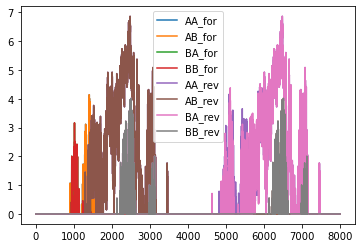

In [24]:
fig, ax = plt.subplots()
df_preds.plot(ax=ax)
# plot_utils.save_fig_and_values(fig, '/home/alex/shared_folder/shared_folder/SCerevisiae/generated/Tosend20240513/preds_nuc_pol_rna_SynAB_8kb_4config', format='svg')

In [25]:
df_preds.to_csv(
    "/home/alex/shared_folder/SCerevisiae/generated/Tosend20240513/preds_rna_SynAB_8kb_4config.csv"
)

In [5]:
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_nuc_name}/preds_{model_nuc_name}_S288c_SynC17C19.npz"
) as f:
    preds_nuc = {k: f[k] for k in f.keys()}
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_pol_name}/preds_{model_pol_name}_S288c_SynC17C19.npz"
) as f:
    preds_pol = {k: f[k] for k in f.keys()}
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_rna_name}/preds_{model_rna_name}_S288c_SynC17C19.npz"
) as f:
    preds_rna = {k: f[k] for k in f.keys()}
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_coh_name}/preds_{model_coh_name}_S288c_SynC17C19.npz"
) as f:
    preds_coh = {k: f[k] for k in f.keys()}
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_nuc_name}/preds_{model_nuc_name}_Struhl.npz"
) as f:
    preds_nuc_Struhl = {k: f[k] for k in f.keys()}
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_pol_name}/preds_{model_pol_name}_Struhl.npz"
) as f:
    preds_pol_Struhl = {k: f[k] for k in f.keys()}
with np.load(
    f"/home/alex/shared_folder/SCerevisiae/results/{model_rna_name}/preds_{model_rna_name}_Struhl.npz"
) as f:
    preds_rna_Struhl = {k: f[k] for k in f.keys()}

In [6]:
for filename in [
    f"/home/alex/shared_folder/SCerevisiae/results/{model_nuc_name}/preds_{model_nuc_name}_S288c_SynC17C19.npz",
    f"/home/alex/shared_folder/SCerevisiae/results/{model_pol_name}/preds_{model_pol_name}_S288c_SynC17C19.npz",
    f"/home/alex/shared_folder/SCerevisiae/results/{model_rna_name}/preds_{model_rna_name}_S288c_SynC17C19.npz",
    f"/home/alex/shared_folder/SCerevisiae/results/{model_coh_name}/preds_{model_coh_name}_S288c_SynC17C19.npz"
    f"/home/alex/shared_folder/SCerevisiae/results/{model_nuc_name}/preds_{model_nuc_name}_Struhl.npz",
]:
    with np.load(filename) as f:
        if "RNA" in filename:
            preds = {k: f[k] for k in f.keys()}
        else:
            preds = {}
            for k in f.keys():
                if not k.endswith("_rev"):
                    preds[k] = (f[k] + f[f"{k}_rev"]) / 2
    utils.write_bw(
        f"/home/alex/shared_folder/SCerevisiae/results/ToSend_2024_04_22/{Path(filename).stem}.bw",
        preds,
    )

In [7]:
with pyBigWig.open(
    "/home/alex/shared_folder/SCerevisiae/results/ToSend_2024_04_22/preds_model_myco_nuc_2_S288c_SynC17C19.bw"
) as bw:
    print(bw.chroms())
with pyBigWig.open(
    "/home/alex/shared_folder/SCerevisiae/results/ToSend_2024_04_22/preds_model_myco_nuc_2_Struhl.bw"
) as bw:
    print(bw.chroms())
with pyBigWig.open(
    "/home/alex/shared_folder/SCerevisiae/results/ToSend_2024_04_22/preds_model_myco_coh_14_S288c_SynC17C19.bw"
) as bw:
    print(bw.chroms())
with pyBigWig.open(
    "/home/alex/shared_folder/SCerevisiae/results/ToSend_2024_04_22/preds_model_myco_pol_17_S288c_SynC17C19.bw"
) as bw:
    print(bw.chroms())
with pyBigWig.open(
    "/home/alex/shared_folder/SCerevisiae/results/ToSend_2024_04_22/preds_weight_CNN_RNA_seq_2001_12_8_4_SRR7131299_S288c_SynC17C19.bw"
) as bw:
    print(bw.chroms())

{'VII': 1095069, 'XI': 670945}
{'chrXVII': 27479}
{'VII': 1095069, 'XI': 670945}
{'VII': 1095069, 'XI': 670945}
{'VII': 1095069, 'VII_rev': 1095069, 'XI': 670945, 'XI_rev': 670945}


In [52]:
df_preds = pd.read_csv(
    "/home/alex/shared_folder/SCerevisiae/generated/Tosend20240306/predictions_12synseq_nopol.csv",
    index_col=0,
)
df_preds

,seq0_pol,seq0_nuc,seq0_rna_for,seq0_rna_rev,seq1_pol,seq1_nuc,seq1_rna_for,seq1_rna_rev,seq2_pol,seq2_nuc,...,seq9_rna_for,seq9_rna_rev,seq10_pol,seq10_nuc,seq10_rna_for,seq10_rna_rev,seq11_pol,seq11_nuc,seq11_rna_for,seq11_rna_rev
0,0.0,0.357946,0.0,0.0,0.0,0.233764,0.0,0.0,0.0,0.283803,...,0.0,0.0,0.0,0.155843,0.0,1.324252,0.0,0.371166,0.0,1.386367
1,0.0,0.344591,0.0,0.0,0.0,0.225682,0.0,0.0,0.0,0.291250,...,0.0,0.0,0.0,0.152215,0.0,3.597543,0.0,0.371161,0.0,1.913766
2,0.0,0.338818,0.0,0.0,0.0,0.243043,0.0,0.0,0.0,0.304120,...,0.0,0.0,0.0,0.155877,0.0,1.272711,0.0,0.342061,0.0,0.000000
3,0.0,0.339907,0.0,0.0,0.0,0.252858,0.0,0.0,0.0,0.294481,...,0.0,0.0,0.0,0.167649,0.0,3.177505,0.0,0.367851,0.0,2.734803
4,0.0,0.345554,0.0,0.0,0.0,0.286006,0.0,0.0,0.0,0.271090,...,0.0,0.0,0.0,0.153314,0.0,0.000000,0.0,0.346411,0.0,0.639411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.343522,0.0,0.0,0.0,0.217102,0.0,0.0,0.0,0.316652,...,0.0,0.0,0.0,0.143626,0.0,4.070919,0.0,0.406522,0.0,2.790309
3996,0.0,0.349780,0.0,0.0,0.0,0.229043,0.0,0.0,0.0,0.301793,...,0.0,0.0,0.0,0.130137,0.0,1.448467,0.0,0.393843,0.0,0.000000
3997,0.0,0.338903,0.0,0.0,0.0,0.216798,0.0,0.0,0.0,0.304837,...,0.0,0.0,0.0,0.147356,0.0,3.886265,0.0,0.398185,0.0,1.562418
3998,0.0,0.333787,0.0,0.0,0.0,0.212769,0.0,0.0,0.0,0.304821,...,0.0,0.0,0.0,0.147426,0.0,2.311235,0.0,0.373242,0.0,0.000000


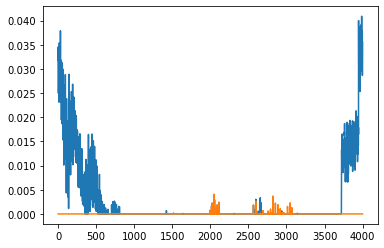

In [47]:
# seqA / seq0 start: VII-19258
# seqB / seq9 start: XI-20342
plt.plot(
    (preds_pol["XI"][20342 : 20342 + 4000] + preds_pol["XI_rev"][20342 : 20342 + 4000])
    / 2
)
plt.plot(df_preds["seq9_pol"])

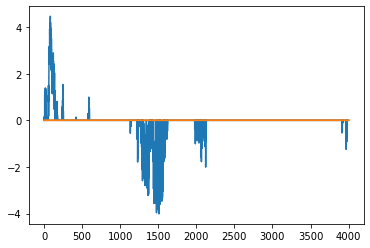

In [46]:
plt.plot(preds_rna["XI"][20342 : 20342 + 4000])
plt.plot(-preds_rna["XI_rev"][20342 : 20342 + 4000], color=colors[0])
plt.plot(df_preds["seq9_rna_for"])
plt.plot(-df_preds["seq9_rna_rev"], color=colors[1])

In [4]:
def character_counts(s):
    unique, counts = np.unique(np.array(list(s)), return_counts=True)
    return dict(zip(unique, counts))


def seq_comp(x: str, y: str):
    x, y = x.upper(), y.upper()
    if len(x) == len(y):
        diff_pos = []
        for i, (a, b) in enumerate(zip(x, y)):
            if a != b:
                diff_pos.append(i)
        if diff_pos == []:
            print("same sequences")
        else:
            print(f"same size: difference at positions {diff_pos}")
            return diff_pos
    else:
        first_diff = 0
        while first_diff < min(len(x), len(y)) and x[first_diff] == y[first_diff]:
            first_diff += 1
        last_diff = -1
        while -last_diff <= min(len(x), len(y)) and x[last_diff] == y[last_diff]:
            last_diff -= 1
        last_diff += 1
        midx = len(x) - first_diff + last_diff
        midy = len(y) - first_diff + last_diff
        print(
            f"Sequences with variable portion X of the form {first_diff}-X-{-last_diff}\n"
            f"\tX are of lengths [{midx}, {midy}]"
        )
        return first_diff, last_diff, midx, midy

In [6]:
chr_id = "chrXVII"
seq = utils.str_to_idx(genome_Struhl[chr_id])
print(len(seq))
character_counts(genome_Struhl[chr_id])

27479


{'A': 6941, 'C': 6523, 'G': 6793, 'T': 7222}

In [11]:
df_sites = pd.read_csv("/home/alex/shared_folder/SCerevisiae/data/sites_Manon.csv")
df_sites

,Name,Chrom,Location,Before the cutting site,After the cutting site
0,Int2,IV,358664-358665,TACGAAAAGAAGTGCACACATTCTTCTTTTTGGCTCATCACAAGTT...,GTGGTGGCTTCGACAACGGCAGTCGTGCTCGGTCGACAACGTGTAT...
1,Int4,VII,19208-19209,AATACACTAAATTGTCCATGTTTTAACTACCATTTCCTTCTAATTT...,TTATCGTGCGAATGGAACTAGAAAACCAATAATCATTGAATAATAT...
2,Int5,VIII,202751-202752,GCGTTTCTCCTCCTCTCTTTTTTTCCTCGAACCGGAGTGGAAGATC...,AAGAGGTCAATTTCGGGACCAACCCTTTTAATCGAAAAAAACGTAA...
3,Int6,IX,337771-337772,TTAAAAGCCCTTATTCAATTGAAGAAATCCCCTGACCTCTGCAAAA...,ACAAGGCCATTAATTCCCTTCGGAGGGCTCCCGATGGGAGGATTCT...
4,Int7,XI,20292-20293,AACGGTCAAGTTTTTACTATCCACATGAGGAGCCGTAATATTCTAA...,TAACAGTAGCATCACACAGAGCATGAGAAAAGCAAGAAAAGTGGAA...
5,Int8,XIII,433662-433663,GATGTTCAAAATCACTCGACCAATTTTCACTACGTCGTCCTGACAG...,CGTGGGAGCACATCCCTTTGAAACGCACCCACGCATTTGCTAAAGA...
6,Int9,XV,702111-702112,CAGATGATCACGAATCCCGAAGCGATGTAATTTTCCGTGAGGCAGT...,ATCTTGGCATCGCTGACGTGTTTTCTTCCAAGATTTAAAGAGGACT...
7,Int10,XVI,589378-589379,GTCTTAAAGCGACCAAATACTTTATTGTTGCGGGCAAACATTATTG...,GAGTGGAAAGCGTTCTTTCAAATGAGGGTAGTAGGAAATTCAGCGG...


In [12]:
for a, b in zip(
    df_sites.loc[:, "Before the cutting site"],
    df_sites.loc[:, "After the cutting site"],
):
    print(len(a), len(b))

500 500
509 514
525 514
500 500
505 510
500 500
500 513
500 500


In [15]:
seqbeforeA = "AATACACTAAATTGTCCATGTTTTAACTACCATTTCCTTCTAATTTTTTTCCTTTCTTAGCTGATTTAATTCATTTATTTGCTGTCGTTTGCATTTACTGACTAAAAAAAGTGTAAAATATGGGAAGCGCAAATTGAAAAGTCGGGTTGCGAAATTACCTGCCAAAAATCCACCTCGTTAATATCTAACAAGATTCAACGCCTGTTGACAAAAGAAACTCGTCAGTCTCTCAGTTTACTTCTATGTTTAACATATTTGCTATGATCCACTCCAGATTCTGCCCAGCCCTCAACTTCACGCCCACGTTGAGAGTACATTCAGTACGTTGAAAATACATTCAGTCACACCCGCAGCACAGCAAGTCGTTTCATCTAAGCTATTTTGATCGTTAGAATATCCACACCTCACAAGTATCGACAATTTAGATGTGTATTGGGTTTTGTCTACGCAAATACCATTAGTTTCACACAAGATGCCATCAGCGCTACTGTAAATAGATTGTTCCTCTGGGCTTGGAGTGAGAGTGACAGAATTCGCATTCTAGAGCTActga"
seqA = "ACTATCAGGAGACAGCAGTCACTATTTGAGGCACCAAATGAACAACACCGTTTCGGGGAAATATTCCGAATAATGTTTGGAATTGTTATCCGAAGTTTAAGTTCCAAATGACAATGCCCTGATACCTAAGTCCTCTGTTTCTACCTATTCTAATTTTATTAATTGACAATGAATGCTTTAATTCTTGGACATCAAGATCCGGACAATAATCATCAGTCGCAACTAATAATCAGTGACTAGAATTGTGCTATATTGGCTAGATCCTCCGGTTCCATGATATTGGATAGAAGCGTTAAGAGGTCGGACTACAACCTGTCTCGATTAGTACTATATGTCGAGCTTAAAAGGGCACTTCATCGAAATATAGGGAATCATATCCTGGCTTGTAAATACCGTTGCTCTTTCAGGTCCATAGTAATCCAAAGTAAGCCCTGGGTTGATTTGCTATGATCAATAGTACTGTCGATTGCGGACATCTAAAACTTGCTGGGATAGTGCTTGATATTAGGAAAATATTCTTAGACTTAACTTGGTCATTTGATATATCTACAACCTTAGGGATATGATATGTTCAAAGCAACGCCAAATAAGCAACAATTTACTGATATTCCTTGAAGCTTCAGCGAACGATTTTCAAAGTCTGGGCACTTATACCTACCAGTAGTCTGATGGGCATCAAGTGTACAAGAATACAAGCTATAAACCAGGTTCGAAGGAATTTCTGAAGTGAGAGTTCCTTCGAGGGACCTATTGATTAGTTGGTAGGGTGGGATGATTTATCTATAAAGCGTTTCCTATTTGCAACCATTAGTGCTGGTCTCGATATATTAGGATTACTGACTGGGATCCCGTTAACTGTCCTGCGGCAATTAAGTGACTGTTTGGATTTCTTTGTCGATTGGCTTCCAAAGAATATCTTTAGGAAGCCTAGTAGGTGAATTTCCAGATTGAAGTAGTTTTAATCAGCACGTCATCAGGAAGTTTTTCAAGCAAAAAGGTTTCCGTTCCAAAAAGTGCCTTTTCGCTGTAAAGTGCGGTGATACTTTGCATCAAATAACACTCCCCAAAGGTCAGATTTCTGAAAGTGAAACGAGAATCCTATGGGTAAATGGTATGCTAGGTGTGTTGTGACCTAGGAGGTTATACCGTACTCCTTGGGATAAAAATGGTATGGATCCGCTTCACTTCACTCAGTCACTGAGATCACAGATTCCTTAAAATTGCTTGGCCCAAGGCACTTACATGATTCTAGCAAGATCCTTTTTGCTATAATGGTGAAGCGCATCCATGACTCAAAACTTTCATTCGACAGCTGTCAGTCTCGGTATCAATCAAATCATGGAAAACGCCACGATTGATAATTCAGAACGATTGGTTACTCCTGCAATTATTCTAATGCAAACCATAAACACAATATCATGACTCAATCTGGTAATAGCATCAACGTATATTGCCACAGGAATCAAACGCATCCTAAAATCTTAGTATGGTCTAGAAATTATGTTTTGATGCAAATGGCTAAGTTACTCGGAACTCTCCTAAATCTGAGACAATTCAATGGTATGCCTTGATCTCCCAGACCCTAGTCCAAACACCCTGAACCCCGTTATGCATATCGAACGGAGCAAATCGATTAATCTGAAGTATGTCCGAACTAATAACGGGCTGATACGGCACTCCTTCATACTGAGTACCACGTGACAACATCTCTAGAATCCATGATCATGTCACTTTTTAGTCACTGACCTTGGGGCACAGCTAACGGGGACAACTTATAATAAAAGTGAAATCAGAGCCTGACGATTACTGGCAATCGGTTGGATGATTATGTTCTTGCCATATCATACTATCGCAGCTGACTCCCATTTTAAAACCTTATTCTTGAAGGCATTTTTGCGGAAAGACTTTATTAGCATTCGGGCAGGGAAGGTCGCATCGTTAACAATGTCACATTCGAAAATTGTCTCGCAGAATTAACTTTGGCTTTAGAACTTAGGATCGGCTACACCTCGTAAGATAGCAATCAGCAATTAAACTGATTCGGAAGATCCCTCTGTTAGAACATTCGATTGTCCATTAACCCAAATGCAAATCGATCATAAGTAAAGTGATCATAATTCCAGCAATAAAGTCAAAAAAGAATAGCCTCAATGACAGAGAATCTCCTCACCACATAGGAGTAGATTCTCAAACCAAACCAACAATATTAGAAAGACATTTTGATATTACCCTCGACTTATATCAGATTTCAATTTGATTTAATGACCTCCAAGGATATATCAATTCCTAATGTCTAGCTTCTGGGTGTTTGAATATCCTGATAGCGTACTTAACTATCGAGGCGCTTATTGTTTTAAGTACCTGGGATTCCATAAGCCTTTGAGGGATTTGAATAAAGGAAGGACATTCTACGTATACAAATATGAAGGCAACCCAACTCCTAAAGAAGCACCTTTCGAATCCAAAATGAATTATGCAAAACCAATGTCATATCTGTCTCGCATAATGAACACATGAGTTTTTAAGCTCGCTACTACACTCTGAACAATTGACACAACAAACAATCCCAAACTATAGTTCTACTTCACCGATTCTTTCCCGGTCTGAACTATATAGTACATCGCTGCTTGATACTCCAAGAATCCGGTCTGAAACTGTGCTACCAATTTATTTCTACCTGGATACTGCTTTAAATTGGCTTCACAGGGTATAAATTATTGTAACAGTGGGATAGTTATTTGTTGGTATCGAACTTTGGAGCTGAGGGTTCCAGTCTGCGAATCAGCCAATGCTTAAAGATCCGGCCTCTTAAATTAAATCCATGAAAATATTCAAAGGCTTGGTGTGCTAAAAAAATCCTAATCATCAACTAGGAAAAAGACTAATGAATGATCCTATTGGTTATATAGTAGATTAATTAAATTAGATCAAGTAGCCACCGGAAAGCATAAGGTTATATAGTATTGATGATTGCCTGGCCTGATTGTATGGAAATTTAATCCAATGTCCTATCGTGTTGGTTTCTGTATTTGAAATAAGCATATACTCTGGTAATAAATGAAGCAAATCTTCTGCTGTGGATTTAGTCTTTATTAAGCGAGCATGGTTATGCCGTAAGACCTAAGGCTCTTTGAACGCTCTTGATTCTGTTCCTTTAGTACTAAGAGTATAATATGTACACCTCCCTGGTATGGGAGTTCCTTATGCCTGTCCTATTTCTGAGTGTCAGAAATCCATTTTAACCTGTATCATGAATATATACAGATCCCAGTGTTTAAGATTCTTAGATCTTACAGCTTCTAACATCCAGGACCCACTGGAACAGATCTATTTCAGTACTCAACATATTCAAAAGCGCATGAGTGTAATACATCTTTAGGCCTTAAGGCGTAAAAAGAAGTAGAAATCCTCTTTAGGTACCGCCAAAGCACGGAATCCTTTTAGAATTAGAACAGCTAAGAAGTGTTTGCAATGGTGTCTCCTGATTTCAGAATTTTGATCTCAAGGGATAGAAATTCTTCAGATTGGAAACCATCAAATTATAGAGTCAGAAAGTAGAGGCTCTTTGGGGCACAGGGGGTTTCCCTATTATTCGGACTACAACTGGATTTTCAGAATCAACTTTCTATCAAGGCGAGGTATCTTGGAGTAATTTCCCTGATACTAGGAAAAGCAGTTCAGAATCATGAATAGGATCTGATTTAGTGACCATTAAGAAAGTAGGTATCTGTTCAATGATTGCCTCATCTAATGGCATCAACCGATTTCAAAATGGCAATTGCTTTCAAATTCTGATTATTGACTGATAATGCCTTAAGTATTGACTTTCTTAGATCTGGAAGATTCTTTGCCTCAGTATAGTAGCAAATCCAATTCACTTGACAAATGATCTGCCTTCTAAAGGAAGATGGTGTTATGACTAAGGTACTGATGAACATTTGATCTCTTGAATACCTAAAGTTCCCAGAATTTTTGGAATATTGGCACTTCAATAATACGA"
seqafterA = "AAGCATACGACTAGTTAGCCTGCAGCATGTACAATGTCTTCCGATGAAGACATGAGTCGACACGGACCTGAGTTAGTTTATCGTGCGAATGGAACTAGAAAACCAATAATCATTGAATAATATATGTGACAGTGACAGGCCACCAGAATAAAGCTAATATCTGGAGGGGTATTTCTTCTTGAGTGAAGAAGAAATATGCTACTTCCAAATTTTAGGACGACAAATCCTCATAATATGAATTAGGCAAATTACAGAATGAAGGGGGTTGAGAAGTCCCACAGCACATCGCTCCTTCGCTAAGAGCTCCACTGCTAAAACAGAAAAAAAAAGTATTAATCAATTGTACTACCATGTTCTTTGTTACTAAACGCGCCTATTTTTTTCGAGAGCCTTTACGAGAGTCAATCAAGCATTCTCCCGCATACTTCGCTAAGAAAAAAGTGATCTTTAATTGGGCCCTTCATCTATCATTTTTGCTTAAGTGGCGTAACTTATTTTATCATTTCCTCTCCCTGCCATCCTCTTTATTTTTGTTCTGTATCACAGCAGTTAATTCAGTTTCCATTCAAAGTATGCCACGGATAACTTGAT"
seqbeforeB = "AACGGTCAAGTTTTTACTATCCACATGAGGAGCCGTAATATTCTAAAGGCAAAAGCATGTGTGCTTGTAAAAAAAAATCAAAAAAAGTTACTGCTCCAAGCCAGCAAGCTTTCTCTTTTGCGAAATCTTTAACACGGTTAAAATCAAAGACAATTACTTCATTGACAAGGTCAATGCTAATATTTACGGTCCCCGCACGAAAGACTCTGAAAAATGTTAAAATTTATAGTGGCTAATGCTAATTCAAGAATAGTCTCGGGTTGTTTGATCACATTATTTTAATTTTTATTGAGCACTGAATAGGACCCGTATGTTCCAATCAGTCTATTTCTTGCAACTTAATCTGGTTTGTTTTTAGGGGAGTGGCATTTTTTTTAGGGTTATTCAAATATTCAATTCTGTAATTTGCTTACGACAAAAAGAAAAGGAGAGATGAAAAAAGGGCGACGGGTATAATCTATTCAGCCGCCAATGTCCCGACGTATGCCAAAATGTGGTGCCGCGGGCCTTAAAACATACCGTGCCGAATTCGTCATCTAGATACGctga"
seqB = "CCTGATTCATAACGCGGTACCGCTTTATGAAATAAGGATGTATTATTGAGATCAGAGTTCATGACCGTGGAGTATTGCAAGTAACTACTGACGGTAATTATCATGAGTCAAGAACTATTTTAGGACATCATACCCCTATTTGAGAACGAATCTTCCCACCTCTTATCTGCATACAACATTGTACCTTTCTTCCTTATTCCCATGATGTATTAAGTCTCCTTGATGATGGTGTCAGTAGATTTCCAGCTACAGATAAGTGTTCTGATTGCTAAAGTCCAAATGTTCGAAATGCCTTCTTAGATATCATAGTTTCTGGATGTTTGAGGATAGGTTCCGCCGGGACCCCCAAGATGAAAACTTGACTTATCAATTTGATTTCAAGATTCTTTGGGTGGTAGTACATTAGGATCCATAGTGGAGATCCAATTCTCCAAAATAATGTTGTTACTGAAAGTGGCAAAGAACTCAATAGTTTCGTTCTGGAAGAGTTCAGACATCTAACATATTTAGTTCAGTCATAACCGTATTCCTCTTTTACTGTACAGAGCTGATTCAAGTTACTTAGCAACAGGATTAGTGGCGTTTGACTAGCTCTGTCAGGGATCCAACTCTTTTGATTTGAAAGGAGAACCTTGAATCCGAAATAGGCTCAACGTAGATAGTGGAGATCAGGTGTACGAATAGTGGGGTATCCTATTATCCAAAATCTCAACTTTAGCGGATTTCAGCACCGAAAGTCCGGGATAAAGTCTGTATGCTATTTACAAGGTTTTGCTTTGAGATTATGACTATATAGGTTGGCCCTAACTCGACTTTGCAATAATACGGCAGTATCCATTGGATGACGGTTCAAATGCATTACTAAGCATTGATCTTATCAAAAAAAGATCTATAGTTTGTAGACTTACCCCAAAATGAAGGTGTACAGGACTCATATGAATACCATGCGGATTTCGAAGCAAACTTTTGGAAAACTCTGATATTTACAGACCGCAATGACTTTGATAAAACAGCAAGGAATAACTGCTACCTTTTTGATTCCCTGAGTAGGCTTTCCAAAGTTTAATATTAGGTCGTCTTAGACTCGAAGTAATGGTAAAGGATCTATCATACCCAATTGATAATGATTATTAGTAGTACTGAGCTTATTGCCATGACCGTGATCTTAATGCTGAATCAAAACTCTGACGTAGAATCCCTGCAATAAGGTAATTCATTTGGCATTACGGCTTCACTTGTATTGGTATTTGTGAATCGTTAGGAATAAAACAAGCTCCTCACTTTTAGTTGCAATGAACGTTCATTGTATAGTGGGCAGCTAGAGGAGCTAGTACCTTTTGAAAATCGTGTCATTCCTTTGACGATTTGTTAATATCTAACCACTCTGATCGCCATAAGTTGATCATACAAATCAAGGGGTTGCACTTCAACCTTACAATCAAAATCTTGCAATCTGAAAAAGCTGATACTGACTTCTCTCTGCAAACTACTGCGAACTAAGCGCGTATTGCTATTTTCGAGGTCATCCACACGTAGTCAATTTCGATTGCAAATCAACATATCACTACTTAATTCAATGACATTTTACTGGGACAGCCGCCGATACAGAATCCCGGTCTCACTTTCTGATTTTAAGTTCCGTCAGACTATCGGGCATACAAAGATTACTTTTAAACTTCAGTCATGTCAAAGATTCACCCTTTCTGCATGCCAGCAGATCTTTCTCTTTAAGTGCAACAAGATGATTCAAGACACGGTATAGTATCCACTGTTCTTCTAAAAGACAACAGGCGAGAGGAGTAGGAATTTTACTAAGAGGTCATCCTAATACAGATGGTCGTTATGAACAGGAAATAAAGTCAGGAATTTGTTTGTACTTTGTCCATTCAAATGGGAACTGATTCGTCCTAAGATAAAAGGTTTCACCTAGCTTGATATTCGCTTCTACCAACAAAATTCTCACTCTGCTTAGAAATGAAGTAATGCTAATCCTCCAGTGGCATTCATAAGCGTAAGATTAGTTTATCGGCCAGGTAAGGTCTTAAAGGTGTAGGCATCTGATTCCCTCTTCAAGCACCGATTGTTAATACTGTGAGACCGATTCTAATGTTGGTGATTTCCAAAATTGGAAATCCATCCGCTAATGTATATTATCAAACAGTCTTGGTATTCGTAGGAAGGCTCTGAATTTCAGAATTGTCATTCCCAAATCTACATATTGATATAAGACAAAGACTGCCTGGCATTAGGGAGATTTTCTGATGGTAGAAGGTGTATTAGAGAGGGAGGCTGGCGACTAAGTCAATATAATTACCATTGTGATAAGACTCAAGCTCGTACGCACCATTAATGTCTGATGTTACCCATACGATGGTCTTGTCTTCCCTTAGAATTTAATTAATCGTATCAGTGTAATCAAGTGGATTGCGGTCCGAAGCTCCTGTAGATTGATATTTCAGGAAGATAGATGATTTACATTATAAAGGGCAATTAAGATTAGTTGAATCAAAATGTCAAAGGATTTTTCGCAAGCTGTGATTTGGGACCAATGGTTGGCTGTAGAACTTTTCATTATCAAAGATTATTCCCTGATAATTTCGGTCAATAAGAATCAATAGGTTTCACGTTGGCACCTTGAAAGCTGTCCTGAGTAATATCTACTCGTTTTGAAGCAAAAATAGTTACGGTAGTGGCTAATTTTTGCATGGAAAACATAATTTTAGACCCTAGAAGCTTCAGAAAATGTGACTAATCTACACCTAATCGACGACCTGGTATGAAGTATCCTGACGACACATGAACTTATTTGGGAGCGTTTGAAAGTAACTTCCATTCAGCCTTTTCTGAATCTAGGGATTTAATGGTAATGCCACTGATATGGTCCTGATGATGGAAATCAAAATTCAGCTACATACCGTCTAAGGACGAAAAGTTTTAGAAGAAAATTAGGATCAATGGGCTACCTAAACAGTTCTCCGATAGAATGCCATAGCAGTTTTCGATGACTTTGCGATTCTTAGGAAACGTATTGAACTAATCTAATTTAGGGGTGAATCAAACCCACGACATTTCAGTCTTCTTGTCGTGTATCTCCTTCTGAGTGGATCATATGAGACCCAACTCCCGAGACTGACGAAGAATCAGAAACCTAATATGATGCCACTGGAGCTTCTCATTCAAGCTGCTATCAAAGAAAGCCTTAACATCACTGCTTAGCGAAAAACTGTACCGACTAAACTGAATTTAAGATCTCTGACGAAAGTTTTGGGTCGTAAGAGAACCCATCTATGCTTAATTTTGATACTTTTTGCTTTAGAAATCCGTAGTACATCCTAACTAGGTGAACATGGGAATCGGTTCATTTGTTCGTATTCTAAACCTGACAATAACATTTGGTACAGCTAATGTAATTCTGCTCATAGCGACCGAGTCCCGGGTCCTAGGATCCTGAATACTTAACGCTTTTTCGTTCTAGATGCGTCAGAAAATACTATTCCGAATCTCGACCCCGACATCTAAGCTTCGTTCGATATTACTTTCATTGCCTATGACCATTTGCAACTTTCACCATAACCATTTCTAAATCAACAAAGGTACTTCAATATCATGATTATTTGTGGTGGGAAAGTTCGATCAGCTAAAAATCCATATTTTCATTGGAATCTTAGTCGTACCAACCCTGATCTCGGTGCTAAGTTCCTACTATAGTAATTTCGTACCGAATCGGGAGTCCTTATCTGAAGTCTCCGATGAGTTGAATGCTATCAAAACCTTTTGTGGATTCAGAACTTAAATGTGAGTTCTGATTGGATCATGGCACTAAAAATGTGCTCCCAAATACTAGCGATCCAAATTGTCAACTATTCATTAATGGTAAAATTGGGTCCCATCGCCCTGTTATTATGTCAATCCTAATATGATAATAATTGGACCTAGGGATGTTTGGGATCTATTGCGGATTATGGAAGTGGTTCTAAAGTCGAAGATTTCCGATTAATAA"
seqafterB = "AAGCATCGAACTAGTTGACCTGCAGGCATTACAATGTCTTCGCTAGAAGACATGAGTCGGGTAAGAGGTGGAGGATTTAACAGTAGCATCACACAGAGCATGAGAAAAGCAAGAAAAGTGGAAGTCTGTATGTCACATTTTTATTGAAAATGCTATTTGCTATAAGGTTCGCTATTCAACTGATTGAACCGAGATAGACAAAATGTTAAACTTTTCATAGAGGCGTTATTGTGATAGGGTTTACGCTGAGAATGGTTGAAACATACTTGCTAATAAACCACGTCACGTCAAAATATCAGTTTTTCTTTTTTAGTTATTCCCTTCTCACTTTTGACTTGAGATGAGATCGTTACACTTTTATTGAATACGAACGGATCACGATACATCCACATATACGAATGTTCGGCCAGACAGGGCATCAGAGTATATACCCTTTTTCCTAAAATGGAAGGGCCCTAGATCGTTGGCATCAGCGGTTACCTAACCGAAGTGGATCAAATCAGCGCCTATTTTTCCGTTTAGAACGATTAGATGCCGTCAATATGTATGTGCTTACTGTATCATCCACGTAGTAAAGCTGGGGCGTA"
print([len(x) for x in [seqbeforeA, seqA, seqafterA]])
print([len(x) for x in [seqbeforeB, seqB, seqafterB]])

[553, 4000, 591]
[549, 4000, 587]


In [91]:
# Changes in chr III, VII (by design), VIII and XI (expected)
for k in genome_Manon.keys():
    kS = f"chr{k}"
    if genome_Struhl[kS] != genome_Manon[k]:
        print(
            f"{kS} is different: in Struhl {len(genome_Struhl[kS])} bp, in Manon {len(genome_Manon[k])} bp"
        )
        seq_comp(genome_Struhl[kS], genome_Manon[k])

chrIII is different: in Struhl 316620 bp, in Manon 315525 bp
Sequences with variable portion X of the form 89323-X-221107
	X are of lengths [6190, 5095]
chrVII is different: in Struhl 1090940 bp, in Manon 1095069 bp
Sequences with variable portion X of the form 18699-X-1071218
	X are of lengths [1023, 5152]
chrVIII is different: in Struhl 562643 bp, in Manon 562778 bp
Sequences with variable portion X of the form 202229-X-359380
	X are of lengths [1034, 1169]
chrXI is different: in Struhl 666816 bp, in Manon 670945 bp
Sequences with variable portion X of the form 19787-X-646014
	X are of lengths [1015, 5144]


In [36]:
assert genome_Manon["VII"][:18699] == genome_Struhl["chrVII"][:18699]  # start-509
# Manon: GGCCGC vs S288c: -
assert (
    genome_Manon["VII"][18705:18976] == genome_Struhl["chrVII"][18699:18970]
)  # start-238
# Manon: C vs S288c: T
assert genome_Manon["VII"][18977:19214] == genome_Struhl["chrVII"][18971:19208]  # start
# Manon: CCTCTGGGCTTGGAGTGAGAGTGACAGAATTCGCATTCTAGAGCTActga (44)
# + seqA
# + aAGCATACGACTAGTTAGCCTGCAGCATGTACAATGTCTTCCGATGAAGACATGAGTCGACACGGACCTGAGTTAGT (77) vs S288c: -
assert (
    genome_Manon["VII"][23335:23420] == genome_Struhl["chrVII"][19208:19293]
)  # stop+85
# Manon: G vs S288c: A
assert (
    genome_Manon["VII"][23421:23851] == genome_Struhl["chrVII"][19294:19724]
)  # stop+516
# Manon: GC vs S288c: -
assert genome_Manon["VII"][23853:] == genome_Struhl["chrVII"][19724:]

In [10]:
genome_Manon["VII"][19258 - 10 : 19258]
genome_Manon["VII"][23258 : 23258 + 10]

'GAGCTActga'

In [37]:
assert genome_Manon["XI"][:19787] == genome_Struhl["chrXI"][:19787]  # start-505
# Manon: GGCCGC vs S288c: -
assert (
    genome_Manon["XI"][19793:19984] == genome_Struhl["chrXI"][19787:19978]
)  # start-314
# Manon: C vs S288c: T
assert genome_Manon["XI"][19985:20298] == genome_Struhl["chrXI"][19979:20292]  # start
# Manon: CCGCGGGCCTTAAAACATACCGTGCCGAATTCGTCATCTAGATACGctga (44)
# + seqB
# + aAGCATCGAACTAGTTGACCTGCAGGCATTACAATGTCTTCGCTAGAAGACATGAGTCGGGTAAGAGGTGGAGGATT (77) vs S288c: -
assert (
    genome_Manon["XI"][24419:24564] == genome_Struhl["chrXI"][20292:20437]
)  # stop+145
# Manon: G vs S288c: A
assert (
    genome_Manon["XI"][24565:24931] == genome_Struhl["chrXI"][20438:20804]
)  # stop+512
# Manon: GC vs S288c: -
assert genome_Manon["XI"][24933:] == genome_Struhl["chrXI"][20804:]

Compare with exp

In [53]:
exp_nuc_Manon = utils.load_bw(
    "/home/alex/shared_folder/SCerevisiae/data/MPerrot_2024_04_16/MP017^mapped_S288c_SynC17C19.bw"
)
print(list(exp_nuc_Manon.keys()))
exp_nuc_Struhl = utils.load_bw(
    "/home/alex/shared_folder/SCerevisiae/data/JSerizay_2024_04_12/SRR22031263_mnase-cov.bw"
)
print(list(exp_nuc_Struhl.keys()))

['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII', 'VIII', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI']
['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chrXVII']


In [57]:
print(
    pearsonr(
        exp_nuc_Struhl["chrXVII"][1000:-1000], preds_nuc_Struhl["chrXVII"][1000:-1000]
    )
)
print(
    pearsonr(
        exp_nuc_Struhl["chrXVII"][1000:-1000],
        preds_nuc_Struhl["chrXVII_rev"][1000:-1000],
    )
)
print(
    pearsonr(
        exp_nuc_Struhl["chrXVII"][1000:-1000],
        (preds_nuc_Struhl["chrXVII"] + preds_nuc_Struhl["chrXVII_rev"])[1000:-1000] / 2,
    )
)

(0.4315894043788129, 0.0)
(0.44917622709492383, 0.0)
(0.4600041144619497, 0.0)


In [60]:
print(
    pearsonr(
        exp_nuc_Manon["VII"][1000:-1000],
        (preds_nuc["VII"] + preds_nuc["VII_rev"])[1000:-1000] / 2,
    )
)
print(
    pearsonr(
        exp_nuc_Manon["XI"][1000:-1000],
        (preds_nuc["XI"] + preds_nuc["XI_rev"])[1000:-1000] / 2,
    )
)

(0.6301683257143385, 0.0)
(0.6127363118242716, 0.0)


(0.5740771149088482, 0.0)
(0.4750015899290314, 2.7285214132888364e-224)


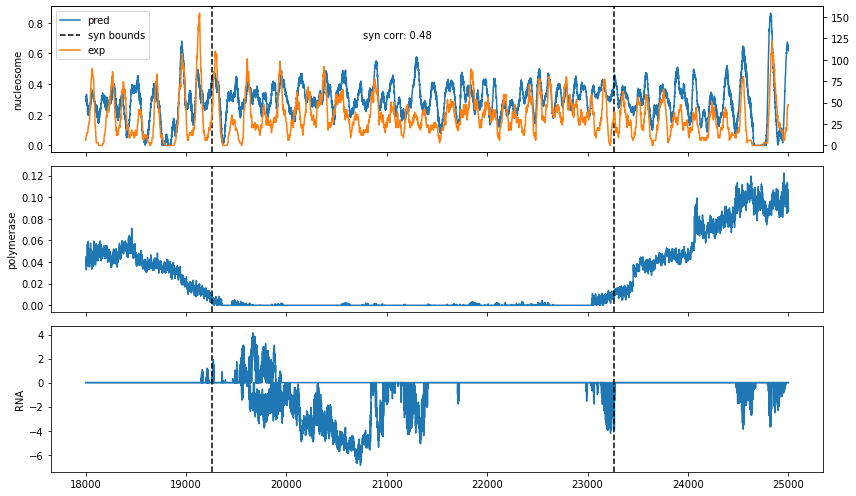

In [94]:
start = 18000
stop = start + 7000
syn_start = 19258
syn_stop = syn_start + 4000
fig, axes = plt.subplots(
    3, 1, figsize=(12, 7), facecolor="w", layout="tight", sharex=True
)
axes[0].plot(
    np.arange(start, stop),
    (preds_nuc["VII"] + preds_nuc["VII_rev"])[start:stop] / 2,
    label="pred",
)
axt = axes[0].twinx()
axt.plot(
    np.arange(start, stop),
    exp_nuc_Manon["VII"][start:stop],
    color=colors[1],
    label="exp",
)
axes[0].annotate(
    f'syn corr: {round(pearsonr((preds_nuc["VII"] + preds_nuc["VII_rev"])[syn_start:syn_stop] / 2, exp_nuc_Manon["VII"][syn_start:syn_stop])[0], 2)}',
    xy=(syn_start + 1500, 0.7),
)
axes[1].plot(
    np.arange(start, stop), (preds_pol["VII"] + preds_pol["VII_rev"])[start:stop] / 2
)
axes[2].plot(np.arange(start, stop), preds_rna["VII"][start:stop])
axes[2].plot(np.arange(start, stop), -preds_rna["VII_rev"][start:stop], color=colors[0])
for ax, annot in zip(axes.flatten(), ["nucleosome", "polymerase", "RNA"]):
    ax.set_ylabel(annot)
    ax.axvline(x=syn_start, color="k", linestyle="--")
    ax.axvline(x=syn_stop, color="k", linestyle="--", label="syn bounds")
han, leg = plot_utils.add_legend([axes[0], axt])
axes[0].legend(han, leg)
print(
    pearsonr(
        (preds_nuc["VII"] + preds_nuc["VII_rev"])[start:stop] / 2,
        exp_nuc_Manon["VII"][start:stop],
    )
)
print(
    pearsonr(
        (preds_nuc["VII"] + preds_nuc["VII_rev"])[syn_start:syn_stop] / 2,
        exp_nuc_Manon["VII"][syn_start:syn_stop],
    )
)
plot_utils.save_fig_and_values(
    fig,
    "/home/alex/shared_folder/SCerevisiae/results/ToSend_2024_04_22/preds_synA",
    format=["png", "svg"],
)

(0.4163034981856929, 1.3942893290934258e-291)
(0.2781794479901545, 5.401414039890087e-72)


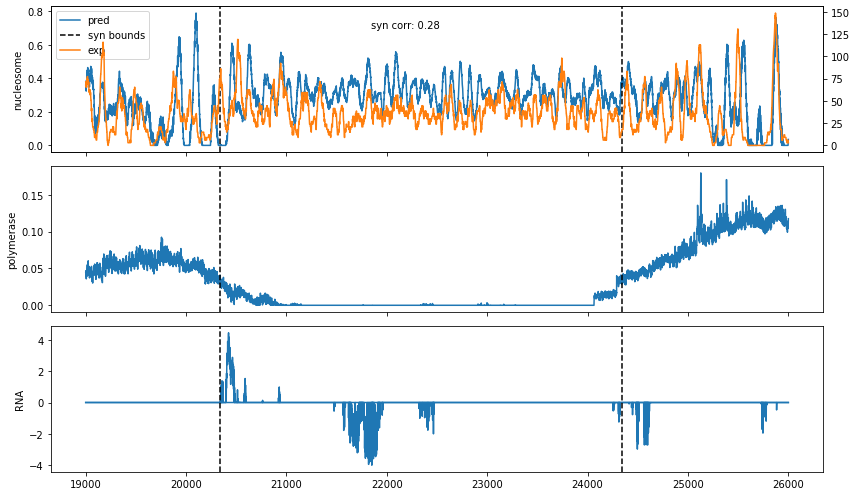

In [95]:
start = 19000
stop = start + 7000
syn_start = 20342
syn_stop = syn_start + 4000
fig, axes = plt.subplots(
    3, 1, figsize=(12, 7), facecolor="w", layout="tight", sharex=True
)
axes[0].plot(
    np.arange(start, stop),
    (preds_nuc["XI"] + preds_nuc["XI_rev"])[start:stop] / 2,
    label="pred",
)
axt = axes[0].twinx()
axt.plot(
    np.arange(start, stop),
    exp_nuc_Manon["XI"][start:stop],
    color=colors[1],
    label="exp",
)
axes[0].annotate(
    f'syn corr: {round(pearsonr((preds_nuc["XI"] + preds_nuc["XI_rev"])[syn_start:syn_stop] / 2, exp_nuc_Manon["XI"][syn_start:syn_stop])[0], 2)}',
    xy=(syn_start + 1500, 0.7),
)
axes[1].plot(
    np.arange(start, stop), (preds_pol["XI"] + preds_pol["XI_rev"])[start:stop] / 2
)
axes[2].plot(np.arange(start, stop), preds_rna["XI"][start:stop])
axes[2].plot(np.arange(start, stop), -preds_rna["XI_rev"][start:stop], color=colors[0])
for ax, annot in zip(axes.flatten(), ["nucleosome", "polymerase", "RNA"]):
    ax.set_ylabel(annot)
    ax.axvline(x=syn_start, color="k", linestyle="--")
    ax.axvline(x=syn_stop, color="k", linestyle="--", label="syn bounds")
han, leg = plot_utils.add_legend([axes[0], axt])
axes[0].legend(han, leg)
print(
    pearsonr(
        (preds_nuc["XI"] + preds_nuc["XI_rev"])[start:stop] / 2,
        exp_nuc_Manon["XI"][start:stop],
    )
)
print(
    pearsonr(
        (preds_nuc["XI"] + preds_nuc["XI_rev"])[syn_start:syn_stop] / 2,
        exp_nuc_Manon["XI"][syn_start:syn_stop],
    )
)
plot_utils.save_fig_and_values(
    fig,
    "/home/alex/shared_folder/SCerevisiae/results/ToSend_2024_04_22/preds_synB",
    format=["png", "svg"],
)

(0.4600041144619497, 0.0)


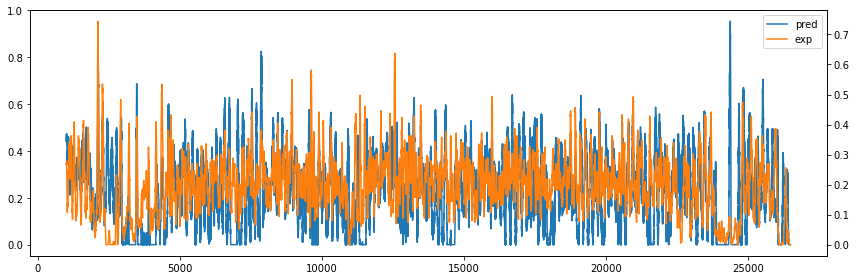

In [117]:
start = 1000
stop = start + 25479
stop = min(stop, 27479)
fig, ax = plt.subplots(1, 1, figsize=(12, 4), facecolor="w", layout="tight")
ax.plot(
    np.arange(start, stop),
    (preds_nuc_Struhl["chrXVII"] + preds_nuc_Struhl["chrXVII_rev"])[start:stop] / 2,
    label="pred",
)
axt = ax.twinx()
axt.plot(
    np.arange(start, stop),
    exp_nuc_Struhl["chrXVII"][start:stop],
    color=colors[1],
    label="exp",
)
han, leg = plot_utils.add_legend([ax, axt])
ax.legend(han, leg)
print(
    pearsonr(
        (preds_nuc_Struhl["chrXVII"] + preds_nuc_Struhl["chrXVII_rev"])[start:stop] / 2,
        exp_nuc_Struhl["chrXVII"][start:stop],
    )
)

/tmp/ipykernel_3151239/1709612595.py:10: RuntimeWarning: divide by zero encountered in true_divide
  axes[1].fill_between(np.arange(start, stop), (myco_pol_ip['chrVII'] / myco_pol_ctrl['chrVII'])[start:stop])
/tmp/ipykernel_3151239/1709612595.py:10: RuntimeWarning: invalid value encountered in true_divide
  axes[1].fill_between(np.arange(start, stop), (myco_pol_ip['chrVII'] / myco_pol_ctrl['chrVII'])[start:stop])
/tmp/ipykernel_3151239/1709612595.py:11: RuntimeWarning: divide by zero encountered in true_divide
  axes[2].fill_between(np.arange(start, stop), (myco_pol_ip2['chrVII'] / myco_pol_ctrl2['chrVII'])[start:stop])
/tmp/ipykernel_3151239/1709612595.py:11: RuntimeWarning: invalid value encountered in true_divide
  axes[2].fill_between(np.arange(start, stop), (myco_pol_ip2['chrVII'] / myco_pol_ctrl2['chrVII'])[start:stop])
/tmp/ipykernel_3151239/1709612595.py:12: RuntimeWarning: divide by zero encountered in true_divide
  axes[3].fill_between(np.arange(start, stop), ((myco_pol_ip['c

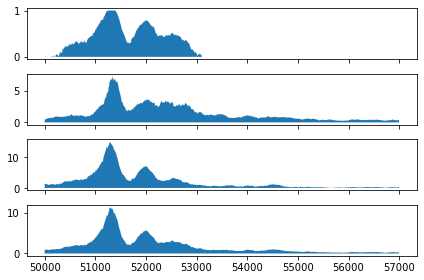

In [104]:
exp_pol = utils.load_bw(
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/labels_myco_pol_log.bw"
)
myco_pol_ip = utils.load_bw(
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703624_PolII_Mmyco_rep1.CPM.bw"
)
myco_pol_ctrl = utils.load_bw(
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703625_PolII-inp_Mmyco_rep1.CPM.bw"
)
myco_pol_ip2 = utils.load_bw(
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703626_PolII_Mmyco_rep2.CPM.bw"
)
myco_pol_ctrl2 = utils.load_bw(
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703627_PolII-inp_Mmyco_rep2.CPM.bw"
)
start = 50000
stop = start + 7000
fig, axes = plt.subplots(4, 1, facecolor="w", layout="tight", sharex=True)
axes[0].fill_between(np.arange(start, stop), exp_pol["chrVII"][start:stop])
axes[1].fill_between(
    np.arange(start, stop),
    (myco_pol_ip["chrVII"] / myco_pol_ctrl["chrVII"])[start:stop],
)
axes[2].fill_between(
    np.arange(start, stop),
    (myco_pol_ip2["chrVII"] / myco_pol_ctrl2["chrVII"])[start:stop],
)
axes[3].fill_between(
    np.arange(start, stop),
    (
        (myco_pol_ip["chrVII"] + myco_pol_ip2["chrVII"])
        / (myco_pol_ctrl["chrVII"] + myco_pol_ctrl2["chrVII"])
    )[start:stop],
)